# Adaptive PDE discretizations on cartesian grids
## Volume : Non-divergence form PDEs
## Part : One space dimension
## Chapter : Static problems

This notebook illustrates the use of monotone finite difference schemes to compute viscosity solutions of PDEs, in one space dimension. (See the other notebooks for two dimensional examples.) We address both first order and second order, linear and non-linear schemes. 

For the best convenience, the numerical scheme jacobian matrix is assembled using automatic differentiation.


[**Summary**](Summary.ipynb) of volume Non-Divergence form PDEs, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. A first order linear equation](#1.-A-first-order-linear-equation)
  * [2. A second order linear equation](#2.-A-second-order-linear-equation)
  * [3. A non-linear equation](#3.-A-non-linear-equation)



**Acknowledgement.** The experiments presented in these notebooks are part of ongoing research, 
some of it with PhD student Guillaume Bonnet, in co-direction with Frederic Bonnans, 
and PhD student François Desquilbet, in co-direction with Ludovic Métivier.

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; TocTools.displayTOC('MonotoneSchemes1D','NonDiv')

In [2]:
from agd import FiniteDifferences as fd
from agd import AutomaticDifferentiation as ad

In [3]:
import numpy as np
import matplotlib.pyplot as plt

Some utility functions

In [4]:
newton_root = ad.Optimization.newton_root
stop = ad.Optimization.stop_default
def LInfNorm(a): return np.max(np.abs(np.array(a)))

## 1. A first order linear equation

We numerically compute the *viscosity* solution of the equation
$$
    f(x) - u'(x)=0
$$
over some interval, with dirichlet boundary conditions.
Unless the mean value of $f$ is compatible with the boundary conditions, this equation admits no classical solution. However the *viscosity* solution exists and is unique. It has a jump at the left endpoint. 

The monotone numerical scheme for this equation is 
$$
    f(x) - \frac{u(x+h)-u(x)} h = 0,
$$
in the interior, with the adequate boundary conditions.

<!---ExoFR
Compléter la fonction `Scheme` ci-dessous, qui renvoie le résidu du schéma numérique. C'est à dire la quantité qui doit s'annuler pour la solution.
--->

<!---ExoCode
def Scheme(u,f,bc,gridScale):
    residue = 0.*u ### TODO : correction needed. 
    ### Should approximate f-u' 
    ### Hint : fd.DiffUpwind(u,(1,),gridScale)
    residue[0] = u[0]-bc[0]; residue[-1]= u[-1]-bc[1] # u[0]=0 and u[1]-1=0
    return residue
--->

In [5]:
def Scheme(u,f,bc,gridScale):
    residue = f - fd.DiffUpwind(u,(1,),gridScale) # f-u' = 0 
    residue[0] = u[0]-bc[0]; residue[-1]= u[-1]-bc[1] # u[0]=0 and u[1]-1=0
    return residue

In [6]:
X = np.linspace(0,1,21,endpoint=True)
gridScale=X[1]-X[0]
f = np.sin(np.pi*X)
bc = (0,1)

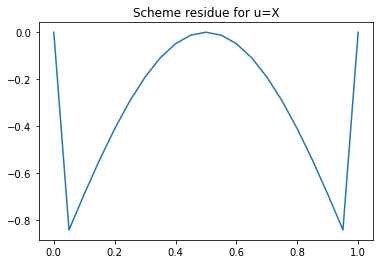

In [7]:
u=X 
residue = Scheme(u,f,bc,gridScale)
plt.title('Scheme residue for u=X')
plt.plot(X,residue);

The next step is to assemble the linear system underlying the PDE. For that purpose we rely on sparse automatic differentiation.

In [8]:
u = ad.Sparse.identity(X.shape)
residue = Scheme(u,f,bc,gridScale)

Finally, we solve and plot the solution. Note the (expected) discontinuity at the boundary due to the selection of the viscosity solution.

In [9]:
solution = residue.solve()
solution_residue = Scheme(solution,f,bc,gridScale)
print(LInfNorm(solution_residue))

3.6637359812630166e-15


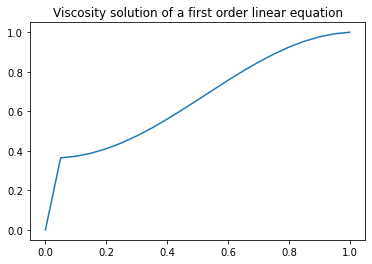

In [10]:
plt.title('Viscosity solution of a first order linear equation')
plt.plot(X,solution);

## 2. A second order linear equation

We consider the second order linear equation 
$$
    -u''(x) + a(x) u'(x) + b(x) = 0,
$$
with again Dirichlet boundary conditions.

There are two main differences w.r.t. the previous example:
* We can use centered finite differences, for the first order term, provided the grid scale is small enough. Indeed, the monotony of the second order derivative dominates the first order.
* There exists a classical solution, so the boundary conditions will be met at both endpoints.

The monotone numerical scheme for this equation is 
$$
    {-} \frac{u(x+h)-2 u(x) +u(x-h)}{h^2} + a(x) \frac{u(x+h)-u(x-h)}{2h} + b(x) = 0
$$
in the interior, with the adequate boundary conditions.

<!---ExoFR
Corriger la fonction suivante, qui doit renvoyer le résidu du schéma numérique ci-dessus.
--->

<!---ExoCode
def Scheme(u,a,b,bc,gridScale):
    residue = 0.*u ### TODO : correction needed.
    ### Hint : fd.Diff2(u,(1,),gridScale)
    ### Hint : fd.DiffCentered(u,(1,),gridScale)
    residue[0] = u[0]-bc[0]; residue[-1]=u[-1]-bc[1]
    return residue
--->

In [11]:
def Scheme(u,a,b,bc,gridScale):
    residue = -fd.Diff2(u,(1,),gridScale) + a*fd.DiffCentered(u,(1,),gridScale) + b
    residue[0] = u[0]-bc[0]; residue[-1]=u[-1]-bc[1]
    return residue

In [12]:
X = np.linspace(0,1,21,endpoint=True)
gridScale=X[1]-X[0]
a = 3*np.sin(np.pi*X)
b=1.
bc = (0,0.1)

In [13]:
u = ad.Sparse.identity(X.shape)
residue = Scheme(u,a,b,bc,gridScale)

In [14]:
solution = u.value+residue.solve()
print(LInfNorm(Scheme(solution,a,b,bc,gridScale)))

1.6431300764452317e-14


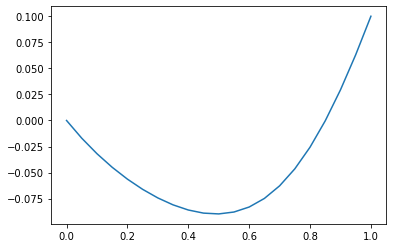

In [15]:
plt.plot(X,solution);

## 3. A non-linear equation

We consider the non-linear equation
$$
     -a(x)u''(x)+
    d(x)|u'(x)-\omega(x)|^2 -1 = 0,
$$
where $a$ is a non-negative function. 
We use again Dirichlet boundary conditions.

When $a\equiv 0$, and $d >0$ this problem becomes a particular case of an eikonal equation, with drift $\omega$.
If $d|\omega|^2\geq 1$, somewhere in the domain, then the undelying optimal control problem looses local controllability, and a discontinuity or boundary layer appears at an endpoint of the domain.

In contrast with the previous examples, this equation is non-linear. Two discretization schemes can be considered, depending on the treatment of the first order term:
* *Centered finite differences.* This discretization is second order consistent, and monotone provided the second order term dominates the first order term. This is typically the case if $a \gtrsim h$, $d = \mathcal O(1)$ and the first order derivative of the solution is bounded. 
$$
    -a(x) \frac{u(x+h)-2 u(x)+u(x-h)} {h^2} + d(x) \left(\frac{u(x+h)-u(x-h)}{2h} -\omega(x)\right)^2 - 1 = 0
$$
* *Upwind finite differences.* This discretization is only first order consistent, but remains monotone even if the second order coefficient $a$ vanishes (we still require $a \geq 0$). 
$$
    -a(x) \frac{u(x+h)-2 u(x)+u(x-h)} {h^2} + d(x) \max\left\{0, \omega(x) - \frac{u(x+h)-u(x)}{h}, -\omega(x) -\frac{u(x-h)-u(x)}{h}\right\}^2 - 1 = 0
$$

<!---ExoFR
Corriger les deux fonctions suivantes, qui doivent renvoyer le résidu des schémas numériques ci-dessus.
--->

<!---ExoCode
def SchemeCentered(u,a,d,omega,bc,h):
    residue = 0.*u ### TODO : correction needed
    ### Hint : fd.DiffCentered(u,(1,),h)
    residue[0] = u[0]-bc[0]; residue[-1]=u[-1]-bc[1]
    return residue

def SchemeUpwind(u,a,d,omega,bc,h):
    maxi = np.maximum
    residue = ### TODO : correction needed
    ### Hint : fd.DiffUpwind(u,(1,),h)
    ### Hint : fd.DiffUpwind(u,(-1,),h)
    residue[0] = u[0]-bc[0]; residue[-1]=u[-1]-bc[1]
    return residue
--->

In [16]:
def SchemeCentered(u,a,d,omega,bc,h):
    residue = (-a*fd.Diff2(u,(1,),h) 
               + d*(fd.DiffCentered(u,(1,),h)-omega)**2
               -1.)
    residue[0] = u[0]-bc[0]; residue[-1]=u[-1]-bc[1]
    return residue

def SchemeUpwind(u,a,d,omega,bc,h):
    maxi = np.maximum
    residue = (-a*fd.Diff2(u,(1,),h) 
               + d*maxi(0.,maxi( omega - fd.DiffUpwind(u,(1,),h), 
                                -omega - fd.DiffUpwind(u,(-1,),h)) )**2
               -1.)
    residue[0] = u[0]-bc[0]; residue[-1]=u[-1]-bc[1]
    return residue

In [17]:
X = np.linspace(0,1,51,endpoint=True)
gridScale=X[1]-X[0]
a=0.1
d=1.
omega=-0.4
bc = (0,0.1)

guess = np.zeros(X.shape)

In [18]:
params = (a,d,omega,bc,gridScale)
print("Centered discretization"); 
solution_centered = newton_root(SchemeCentered,guess,params)
print()
print("Upwind discretization");   
solution_upwind = newton_root(SchemeUpwind,guess,params)

Centered discretization
Iteration: 1  Residue norm: 29.898197384688963
Iteration: 2  Residue norm: 7.21780769314384
Iteration: 3  Residue norm: 1.3527690097988936
Iteration: 4  Residue norm: 0.0536542494204284
Iteration: 5  Residue norm: 3.8327705599972006e-05
Iteration: 6  Residue norm: 1.1766143614977409e-11
Target residue reached. Terminating.

Upwind discretization
Iteration: 1  Residue norm: 29.588778291338784


Iteration: 2  Residue norm: 7.118351544328215
Iteration: 3  Residue norm: 1.362298763130834
Iteration: 4  Residue norm: 0.08101479548291834
Iteration: 5  Residue norm: 0.0002119788463035288
Iteration: 6  Residue norm: 1.0399192618137931e-09
Target residue reached. Terminating.


When the solution is smooth, there is not much difference between the centered and the upwind discretization.

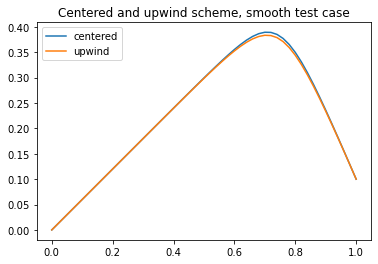

In [19]:
plt.title("Centered and upwind scheme, smooth test case")
plt.plot(X,solution_centered,label="centered")
plt.plot(X,solution_upwind, label="upwind");
plt.legend();

Increasing the drift value yields a boundary layer.
(The first order part of the PDE does not correspond anymore to a locally controllable problem.)
Because the first order derivative of the solution is not bounded, the centered second order scheme looses monotony, and the resulting numerical solution may be incorrect.  

Centered discretization
Iteration: 1  Residue norm: 14.497311217649045
Iteration: 2  Residue norm: 3.772179877026538
Iteration: 3  Residue norm: 0.3176216437018198
Iteration: 4  Residue norm: 0.023603400737066238
Iteration: 5  Residue norm: 0.00010808252080352077
Iteration: 6  Residue norm: 2.191988812683121e-09
Target residue reached. Terminating.

Upwind discretization
Iteration: 1  Residue norm: 6.009152075099174
Iteration: 2  Residue norm: 0.12080838760271462
Iteration: 3  Residue norm: 4.8517600411912554e-05
Iteration: 4  Residue norm: 3.154454475406965e-11
Target residue reached. Terminating.


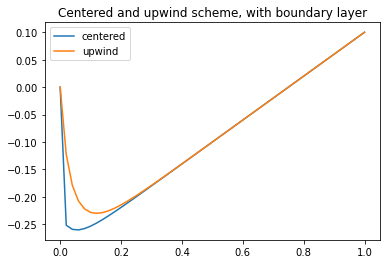

In [20]:
omega2 = 1.4
params = (a,d,omega2,bc,gridScale)
print("Centered discretization"); 
solution_centered = newton_root(SchemeCentered,guess,params)
print()
print("Upwind discretization");   
solution_upwind = newton_root(SchemeUpwind,guess,params)

plt.title("Centered and upwind scheme, with boundary layer")
plt.plot(X,solution_centered,label="centered")
plt.plot(X,solution_upwind, label="upwind");
plt.legend();

We next remove the second order term, to get the standard eikonal equation.
A problem arises : the jacobian matrix $J$ of the scheme may not be invertible. Fortunately, by degenerate ellipticity, 
$$
    J+\epsilon \mathrm{Id},
$$
is guaranteed to be invertible, for any $\epsilon>0$. 
(The non-invertibility issue may or may not arise depending on the initial conditions.)

We note in this setting that:
* The centered scheme looses monotonicity, and indeed fails to converge.
* The upwind scheme requires $\epsilon>0$ for solving the linear problems.

Centered discretization
Iteration: 1  Residue norm: 1.0170748113143362
Iteration: 2  Residue norm: 35.89906406436521
Iteration: 3  Residue norm: 8.359333644915644
Iteration: 4  Residue norm: 1.4874380253486335
Iteration: 5  Residue norm: 0.6737384280319165
Iteration: 6  Residue norm: 0.6534559817560939
Iteration: 8  Residue norm: 0.64666040248134
Iteration: 10  Residue norm: 0.6458469590647455
Iteration: 12  Residue norm: 0.6457316194653284
Iteration: 14  Residue norm: 0.6457015780480149
Iteration: 16  Residue norm: 0.6456941027843064
Iteration: 20  Residue norm: 0.645691765774624
Max iterations exceeded. Aborting.

Upwind discretization
Iteration: 1  Residue norm: 705.2273268435152
Iteration: 2  Residue norm: 176.1775175937498
Iteration: 3  Residue norm: 96.75023856617977
Iteration: 4  Residue norm: 91.71254599177115
Iteration: 5  Residue norm: 79.86122878563275
Iteration: 6  Residue norm: 64.05715532164896
Iteration: 8  Residue norm: 32.52211848671483
Iteration: 10  Residue norm: 11.

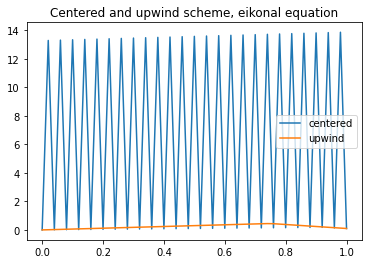

In [21]:
# No second order term
a2=0
params = (a2,d,omega,bc,gridScale)

# Relaxation of the linear problems
epsilon=1
relax = epsilon*ad.Sparse.identity(X.shape)

print("Centered discretization"); 
solution_centered = newton_root(SchemeCentered,guess,params,relax=relax,
                               stop=stop(niter_max=20,raise_on_abort=False))
print()
print("Upwind discretization");   
solution_upwind = newton_root(SchemeUpwind,guess,params,relax=relax)

plt.title("Centered and upwind scheme, eikonal equation")
plt.plot(X,solution_centered,label="centered")
plt.plot(X,solution_upwind, label="upwind");
plt.legend();

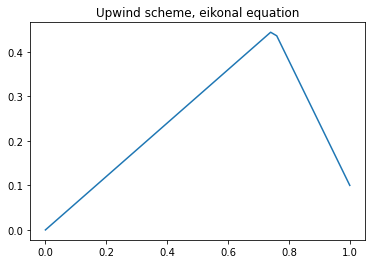

In [22]:
plt.title("Upwind scheme, eikonal equation")
plt.plot(X,solution_upwind);